In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from chemblmltools import chembl_activity_target

# 1. Load data

Load data from ChEMBL for selected pathogen.

The eskape_pathogen_text is the text search string (case insensitive) to look for in the organism field of the ChEMBL database.

The list and counts of selected organism values will be displayed. Make sure to review this list, in case
there are additional organisms that should have been excluded.

In [2]:
pathogen_search_string = 'Staphylococcus aureus'

# NOTE: Use any of the following text strings to find the ESKAPE pathogens:
#     'Enterococcus faecium'
#     'Staphylococcus aureus'
#     'Klebsiella pneumoniae'
#     'Acinetobacter baumannii'
#     'Pseudomonas aeruginosa'
#     'Enterobacter'

# Get activity_target data from chembl
df = chembl_activity_target(
        db_user='chembl_user',
        db_password='aaa',
        organism_contains= pathogen_search_string)

138376 rows extracted from Chembl:
138376 cases in resulting dataset.
Selected organisms:
Staphylococcus aureus                                129530
Staphylococcus aureus subsp. aureus                    6325
Staphylococcus aureus subsp. aureus RN4220              631
Staphylococcus aureus (strain N315)                     605
Staphylococcus aureus (strain Newman)                   312
Staphylococcus aureus (strain NCTC 8325)                272
Staphylococcus aureus subsp. aureus MW2                 199
Staphylococcus aureus (strain MRSA252)                  178
Staphylococcus aureus (strain Mu50 / ATCC 700699)       110
Staphylococcus aureus subsp. aureus Mu50                 65
Staphylococcus aureus (strain COL)                       51
Staphylococcus aureus (strain MSSA476)                   49
Staphylococcus aureus (strain NCTC 8325 / PS 47)         20
Staphylococcus aureus (strain MW2)                       16
Staphylococcus aureus (strain USA300)                     7
Staphyloco

In [3]:
# Import activity_stds_lookup
# This table is included in the repository. It is simply a dump of ChEMBL table ACTIVITY_STDS_LOOKUP.

df_value_ranges = pd.read_csv(
        '../data/activity_stds_lookup.csv', 
        usecols=['standard_type', 'standard_units', 'normal_range_min', 'normal_range_max'],
        na_values='-')
print(df_value_ranges.shape)

(150, 4)


# 2. Descriptive exploration

In [4]:
# Describe numerical variables: pchembl_value, standard_value, year
pd.set_option("display.precision", 2)
df[['pchembl_value', 'standard_value', 'year']].describe()

,pchembl_value,standard_value,year
count,4033.00,1.27e+05,131331.00
mean,6.05,4.67e+05,2010.80
std,1.38,2.67e+07,8.07
min,3.00,-1.27e+02,1976.00
25%,5.00,2.00e+00,2008.00
50%,5.75,1.48e+01,2012.00
75%,6.96,7.60e+01,2016.00
max,11.70,6.90e+09,2021.00


In [5]:
# Describe categorical variable: standard_units
df[['standard_units']].describe(include='all')

,standard_units
count,122149
unique,125
top,ug.mL-1
freq,71171


In [6]:
# Counts of categorical variable: standard_units
print(df['standard_units'].value_counts(), '\n\n')

ug.mL-1     71171
nM          16371
%           11790
mm          11596
ug ml-1      4900
            ...  
ng/ml           1
10^7CFU         1
ug/sq.cm        1
ug l-1          1
10^4/M/s        1
Name: standard_units, Length: 125, dtype: int64 




In [7]:
# Counts of categorical variable: standard_relation
df.standard_relation.value_counts()

=     106670
>      16153
<       1896
>=      1005
<=       961
~          8
Name: standard_relation, dtype: int64

In [8]:
# Counts of categorical variable: activity_comment
df.activity_comment.value_counts()[:30]

Not Active                        6847
Not Determined                    1926
Average; N=2                      1912
Active                            1582
Average; N=2; Conc=25 Um ;        1566
Average; N=4                      1507
active                             497
Average; N=3                       352
Dose-dependent effect              291
Non-Toxic                          155
Median N= 2                        131
Non-toxic                           51
Not Evaluated                       39
Tde                                 34
tde                                 32
Toxic                               21
No significant inhibition           19
Negative                            18
Average n= 2; Conc: 32 ug.mL-1      18
Nd(Insoluble)                       18
Not Tested                          15
Median N= 2; Maxinhib 12.2 Pct      11
Median N= 2; Maxinhib 13.3 Pct      11
Median N= 2; Maxinhib 10.2 Pct       9
resistant                            9
ND(Insoluble)            

# 3. Data cleaning

In [9]:
# Discard rows with missing standard_value
print('Cases with missing value discarded:', df[df.standard_value.isnull()].shape[0])
df = df[df.standard_value.notnull()].copy()

Cases with missing value discarded: 11188


### Cap values out of normal range

In [10]:
from collections import defaultdict

def default_value():
    return np.nan

# Mapping from (type,units) to minimum acceptable value
dict_type_units_min = defaultdict(default_value, zip(zip(df_value_ranges.standard_type, df_value_ranges.standard_units),
                           df_value_ranges.normal_range_min))

# Mapping from (type,units) to maximum acceptable value
dict_type_units_max = defaultdict(default_value, zip(zip(df_value_ranges.standard_type, df_value_ranges.standard_units),
                           df_value_ranges.normal_range_max))


In [11]:
# Cap values so that they can't be more than normal_range_max or less than normal_range_min
# New column is_value_capped created to indicate if capping took place.

df['is_value_capped'] = False

for index, row in df.iterrows():
    # Get minimum and maximum allowable values depending on units and 
    min_value = dict_type_units_min[(row.standard_type, row.standard_units)]
    max_value = dict_type_units_max[(row.standard_type, row.standard_units)]
    if row.standard_value < min_value:
        # Cap value and indicate it in is_value_capped
        df.at[index, 'standard_value'] = min_value
        df.at[index, 'is_value_capped'] = True
    elif row.standard_value > max_value:
        # Cap value and indicate it in is_value_capped
        df.at[index, 'standard_value'] = max_value
        df.at[index, 'is_value_capped'] = True
        
# Explore how many have been capped
df.is_value_capped.value_counts()

False    125327
True       1861
Name: is_value_capped, dtype: int64

In [12]:
# See how many have been capped by type and units

df_count_capped = df.groupby(['standard_type','standard_units']).is_value_capped\
            .agg(['count', 'sum'])\
            .reset_index()\
            .rename(columns={'sum':'num_capped'})

# Calculate ratio
df_count_capped['ratio_capped'] = df_count_capped['num_capped'] / df_count_capped['count']

# Avoid displaying float scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df_count_capped[df_count_capped['count']>=200].sort_values(by=['ratio_capped', 'num_capped'], ascending=False)


,standard_type,standard_units,count,num_capped,ratio_capped
109,IC50,ug.mL-1,1597,252,0.158
107,IC50,nM,4767,538,0.113
145,Ki,nM,363,24,0.066
127,Inhibition,%,7223,365,0.051
79,EC50,nM,489,23,0.047
226,MIC,nM,10029,177,0.018
248,MIC50,ug.mL-1,1169,17,0.015
255,MIC90,ug.mL-1,1482,17,0.011
238,MIC,ug.mL-1,66472,397,0.006
123,IZ,mm,11532,20,0.002


**Comment:** The percent of capped values is only high in a few cases of (type, units)

In [13]:
# See how many have been capped by assay

df_count_capped = df.groupby(['assay_id']).is_value_capped\
            .agg(['count', 'sum'])\
            .reset_index()\
            .rename(columns={'sum':'num_capped'})

# Calculate ratio
df_count_capped['ratio_capped'] = df_count_capped['num_capped'] / df_count_capped['count']

# Avoid displaying float scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df_count_capped[df_count_capped['count']>=10].sort_values(by=['ratio_capped', 'num_capped'], ascending=False).head(30)


,assay_id,count,num_capped,ratio_capped
2821,457869,42,42,1.000
4877,615990,21,21,1.000
43,53154,20,20,1.000
285,198700,19,19,1.000
388,202944,17,17,1.000
8493,812777,16,16,1.000
9150,901990,16,16,1.000
103,153204,14,14,1.000
113,153519,14,14,1.000
115,153656,14,14,1.000


**Comment:** There are a few assays where all the values are capped, but none of them has a very large number of activities (máximum 42 activities, the majority less than 20 activities).

In [14]:
# See a few examples of capped values
df[df.is_value_capped].iloc[1000:, 5:20].head()

,assay_bao_format,compound_chembl_id,canonical_smiles,standard_type,standard_value,standard_units,standard_relation,pchembl_value,activity_comment,target_chembl_id,target_type,target_organism,target_pref_name,target_tax_id,protein_accession_class
67561,BAO_0000218,CHEMBL3273428,CC(NC(=O)[C@@H](C)N)c1nn[nH]n1,MIC,5000.000,ug.mL-1,>,NaN,None,CHEMBL352,ORGANISM,Staphylococcus aureus,Staphylococcus aureus,1280,None
67562,BAO_0000218,CHEMBL3273429,Br.C[C@@H](N)C(=O)N[C@H](C)C(=O)NO,MIC,5000.000,ug.mL-1,>,NaN,None,CHEMBL352,ORGANISM,Staphylococcus aureus,Staphylococcus aureus,1280,None
67563,BAO_0000218,CHEMBL3273430,CC(=O)C(C)NC(=O)[C@@H](C)NC(=O)OCc1ccccc1,MIC,5000.000,ug.mL-1,>,NaN,None,CHEMBL352,ORGANISM,Staphylococcus aureus,Staphylococcus aureus,1280,None
67564,BAO_0000218,CHEMBL3273431,Br.CC(NC(=O)[C@@H](C)N)C(=O)NO,MIC,5000.000,ug.mL-1,>,NaN,None,CHEMBL352,ORGANISM,Staphylococcus aureus,Staphylococcus aureus,1280,None
68090,BAO_0000218,CHEMBL3287148,CN(CCOc1ccc(C(=N)N)cc1)CCOc1ccc(C(=N)N)cc1.Cl,MIC,10000000.000,nM,=,NaN,None,CHEMBL352,ORGANISM,Staphylococcus aureus,Staphylococcus aureus,1280,None


### Clean units

In [15]:
# Clean values of standard_units
df['standard_units'] = np.where(df.standard_units=='ug ml-1', 'ug.mL-1', df.standard_units)
df['standard_units'] = np.where(df.standard_units=='ppm', 'p.p.m.', df.standard_units)
df['standard_units'] = np.where(df.standard_units.str.lower()=='mg kg-1', 'mg.kg-1', df.standard_units)

# standard_units: convert NaN into the text 'N/A'
df['standard_units'] = df['standard_units'].fillna('N/A')

# 4. Percentiles of standard_value by (type, units)

In [16]:
# Distribution of standard_value grouped by standard_type and standard_units
df_value_by_unit = df.groupby(['standard_type', 'standard_units'])['standard_value']\
            .describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95])\
            .drop(columns=['mean', 'std', 'min', 'max'])\
            .sort_values(['count'], ascending=False)\
            .reset_index()

# df_value_by_unit.head(30)
# Show in alphabetical order (order case insensitive)
df_value_by_unit.head(30).sort_values(by=['standard_type', 'standard_units'],
                                      key=lambda col: col.str.lower())

,standard_type,standard_units,count,5%,25%,50%,75%,95%
14,-logMIC,N/A,844.000,0.950,1.289,2.040,4.300,6.441
6,Activity,%,2127.000,-3.300,11.800,49.000,90.000,101.000
28,Activity,log10CFU/ml,184.000,0.015,1.975,3.770,5.883,10.425
29,Activity,N/A,178.000,0.000,0.325,0.950,4.845,77.000
17,Activity,ug.mL-1,396.000,0.500,6.250,32.000,128.000,500.000
16,EC50,nM,489.000,134.000,910.000,4700.000,47000.000,100000.000
12,ED50,mg.kg-1,1001.000,0.590,2.210,6.250,16.200,50.000
11,FC,N/A,1077.000,0.000,1.920,3.000,8.000,64.000
22,FICI,N/A,310.000,0.100,0.292,0.555,1.288,8.100
13,GI,%,919.000,-13.777,16.445,56.000,90.000,99.000


In [17]:
# Optional - Export to csv
# df_value_by_unit.to_csv('../data/value_by_type_and_unit.csv')
# NOTE: When importing the csv to Excel, issues were found with some values 
# of standard_type, e.g. "-logMIC". Pending to adapt export options to fix this

In [18]:
# Sort by standard_units. This helps identify if same unit has different spellings.
# This insight may then be used in the data cleaning step.
# Ignore rare combinations (count less than 5)
df_value_by_unit[df_value_by_unit['count']>=5].sort_values(['standard_units', 'count'], ascending=False)

,standard_type,standard_units,count,5%,25%,50%,75%,95%
137,MBC,umol/ml,23.000,0.261,0.380,0.460,0.500,0.540
233,MIC100,umol/ml,6.000,2.881,3.380,5.966,11.118,109.740
174,LC50,umol/g,15.000,1.000,1.250,2.000,3.000,3.950
51,MIC95,umol/L,81.000,0.980,7.810,125.000,500.000,500.000
136,MBC,umol/L,23.000,1.000,1.350,2.000,14.900,59.800
...,...,...,...,...,...,...,...,...
146,Ratio,%,21.000,8.000,32.000,32.000,64.000,512.000
165,mortality,%,16.000,7.500,27.500,63.000,80.750,92.500
214,MLC,%,8.000,0.442,0.795,1.760,4.220,8.426
221,MIC,%,6.000,7.613,30.000,30.000,30.000,30.750


## Histograms of standard_value by (type, units)

In [19]:
# Select the most common combinations of (standard_type, standard_units).
# One histogram will be created for each selected combination.
# df_common_units will contain the filtered data for the selected combinations.

NUM_VALUES_TO_SELECT = 30

unit_counts = df[['standard_type', 'standard_units']].value_counts().reset_index()
print(unit_counts[:NUM_VALUES_TO_SELECT])
print()

sel_units = unit_counts.iloc[:NUM_VALUES_TO_SELECT,:2]

   standard_type standard_units      0
0            MIC        ug.mL-1  66472
1             IZ             mm  11532
2            MIC             nM  10029
3     Inhibition              %   7223
4           IC50             nM   4767
5            MBC        ug.mL-1   2584
6       Activity              %   2127
7          Ratio            N/A   1800
8           IC50        ug.mL-1   1597
9          MIC90        ug.mL-1   1482
10         MIC50        ug.mL-1   1169
11            FC            N/A   1077
12          ED50        mg.kg-1   1001
13            GI              %    919
14       -logMIC            N/A    844
15           MBC             uM    664
16          EC50             nM    489
17      Activity        ug.mL-1    396
18         MIC99        ug.mL-1    373
19            Ki             nM    363
20      Survival              %    321
21   log10CFU/ml            N/A    320
22          FICI            N/A    310
23      log10cfu            N/A    273
24         MIC90         

In [20]:
# Use merge to select only the rows from df that exist in dataframe sel_unit
df_sel_units = df.merge(sel_units)
print('df_sel_units.shape:', df_sel_units.shape)

df_sel_units.shape: (119344, 29)


### Histogram of value grouped by assay type and units

We will exclude extreme values from the histograms, otherwise the scale makes the data difficult to see.

The histograms will be saved in a pdf file.

In [21]:
def identify_outliers(x):
    """Function to identify outliers.
    Criterion: x is an outlier if (x < Q1 - 5*IQR) or (x > Q3 + 5*IQR)
    
    Input:
        x: Data vector
    Returns:
        is_outlier: Boolean vector component i is True if x[i] is an outlier
    """
    x = list(x)  # Convert to list
    
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1  # Inter-quartile range
    lower_limit = q1 - 5*iqr
    upper_limit = q3 + 5*iqr
    
    return (x < lower_limit) | (x > upper_limit)

# x_test = [1, 2, 3, 4, 20]
# identify_outliers(x_test)


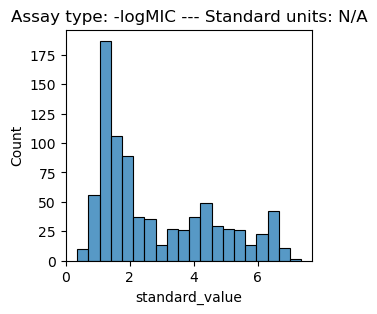

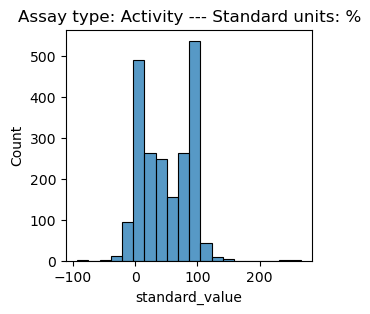

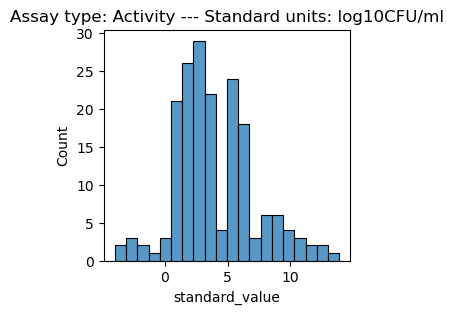

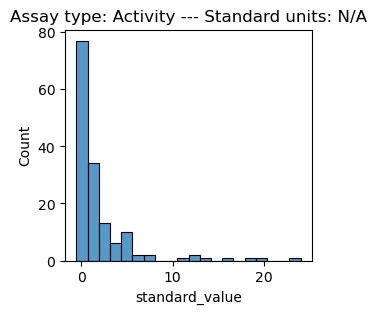

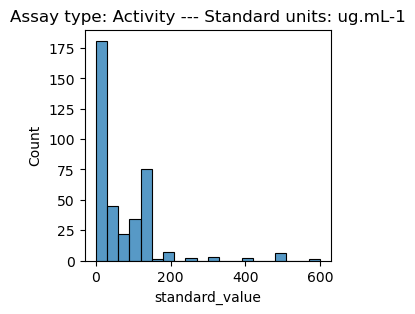

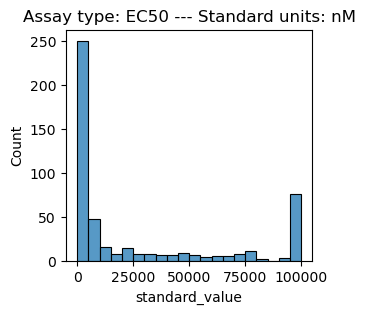

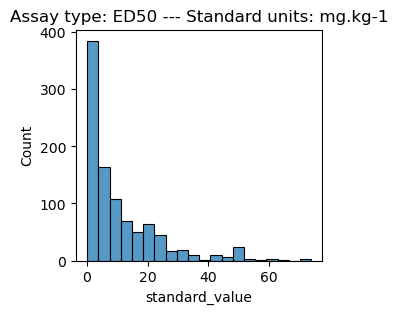

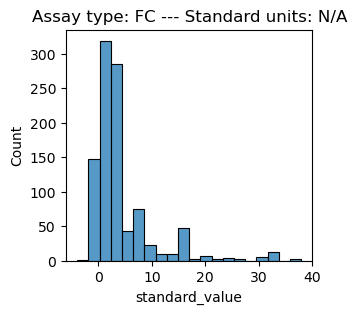

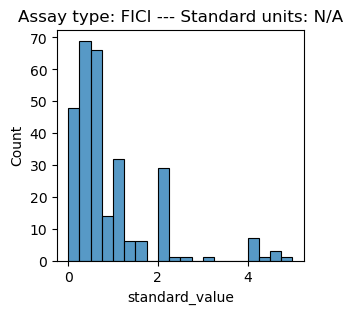

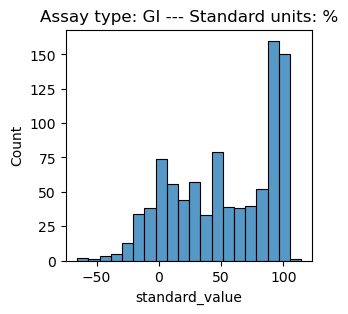

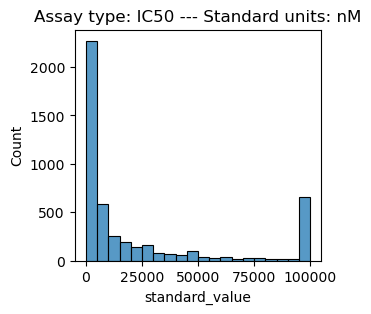

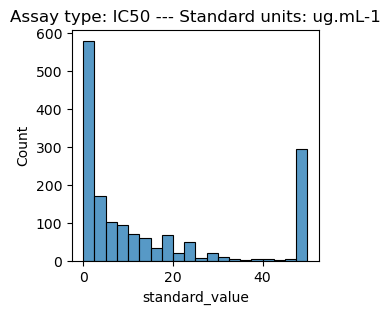

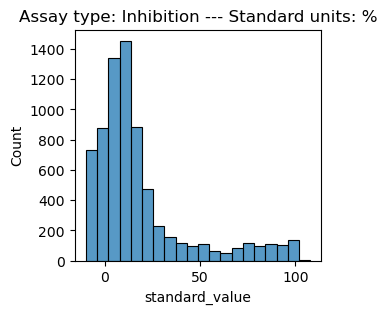

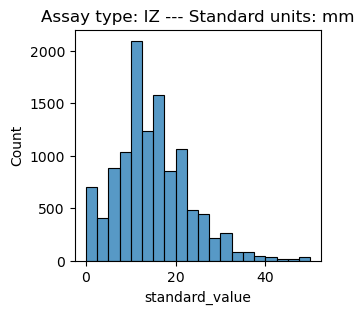

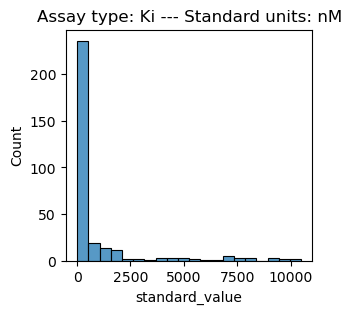

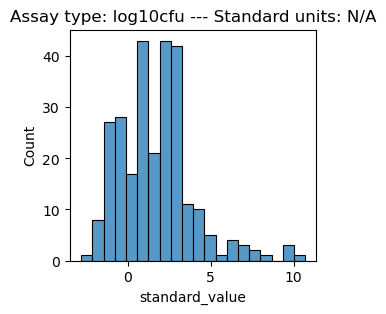

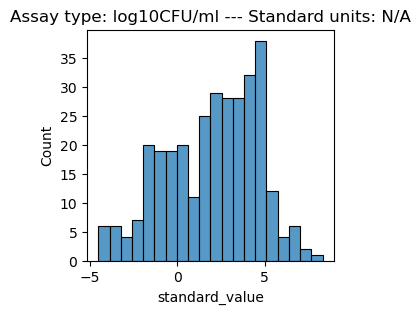

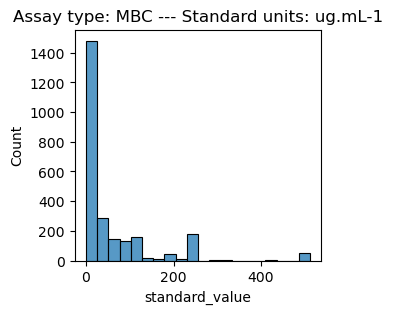

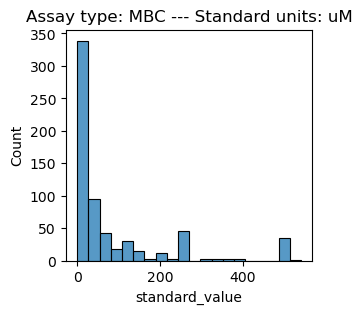

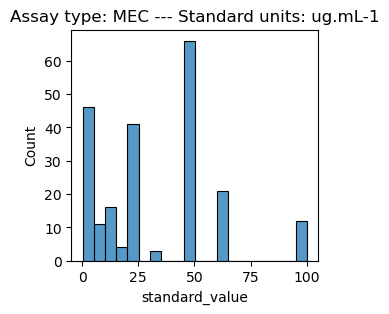

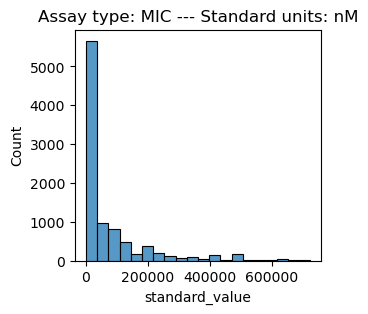

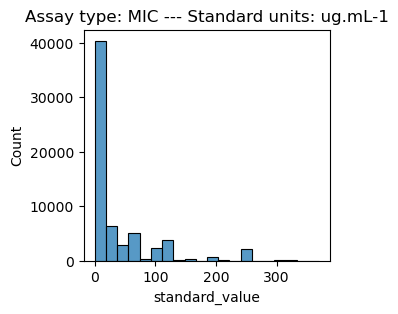

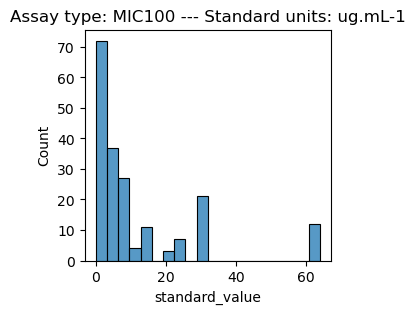

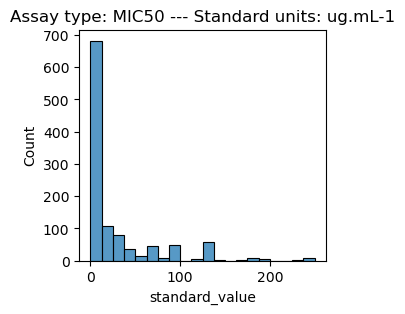

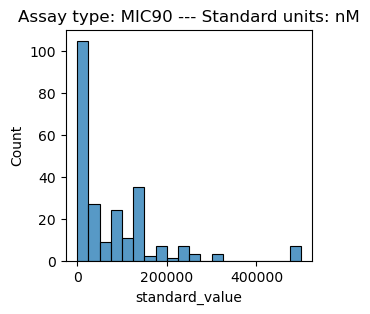

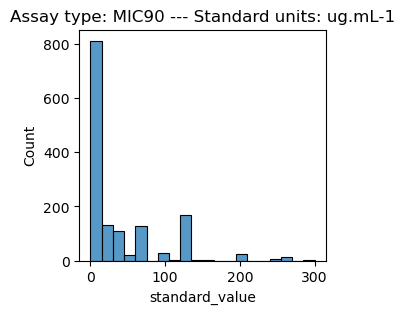

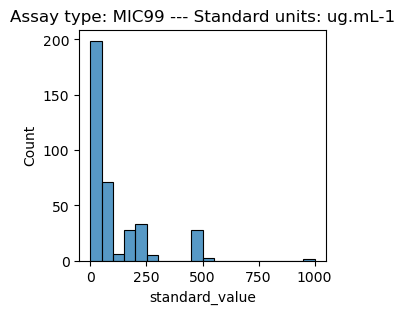

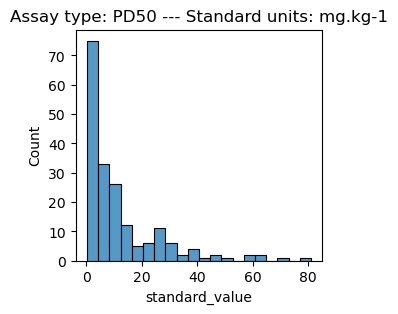

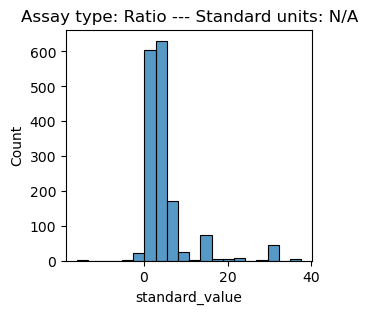

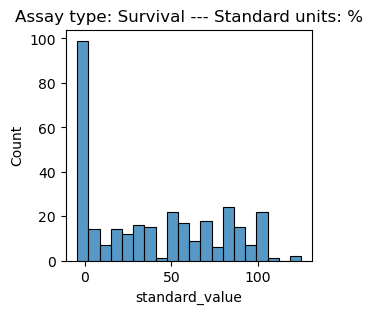

In [22]:
from matplotlib.backends.backend_pdf import PdfPages

# Order by 'standard_type', 'standard_units' in a non-case-sensitive way
df_sel_units.sort_values(by=['standard_type', 'standard_units'],
                         inplace=True, key=lambda col: col.str.lower())

# Generate plots and save them in a single pdf file
with PdfPages('../tmp/histograms_boxplots.pdf') as pdf:
    for i, group in (df_sel_units.groupby(['standard_type', 'standard_units'], sort=False)):
        # exclude outliers in the plots
        non_outliers = pd.DataFrame(
                group.standard_value.where(~identify_outliers(group.standard_value)))  
        
        fig = plt.figure(figsize=(7, 3))
        ax = fig.add_subplot(1, 2, 1)
        sns.histplot(data=non_outliers, x='standard_value', bins=20).set(title=f'Assay type: {i[0]} --- Standard units: {i[1]}')

        pdf.savefig(fig)
        plt.show()

### Histogram of the 5 top cases with marks for the cutoff values

In [23]:
group

,doc_id,assay_id,activity_id,assay_type,assay_confidence_score,assay_bao_format,compound_chembl_id,canonical_smiles,standard_type,standard_value,...,protein_accession_class,year,pubmed_id,assay_chembl_id,count_activity_rows,doc_id_all,assay_id_all,activity_id_all,assay_description,is_value_capped
117058,50474,616454,3197580,F,1,BAO_0000218,CHEMBL1080548,Cn1c(=O)c2c(-c3ccccc3)n3c(c2n(C)c1=O)C(c1cccc(...,Survival,64.000,...,None,2010.000,20138521.000,CHEMBL1101646,1,50474,616454,3197580,Antibacterial activity against Staphylococcus ...,False
117059,50474,616455,3197560,F,1,BAO_0000218,CHEMBL1080548,Cn1c(=O)c2c(-c3ccccc3)n3c(c2n(C)c1=O)C(c1cccc(...,Survival,74.000,...,None,2010.000,20138521.000,CHEMBL1101647,1,50474,616455,3197560,Antibacterial activity against tarO deficient ...,False
117060,50474,616454,3197563,F,1,BAO_0000218,CHEMBL1081127,Cc1cc2c(cc1C)-n1c(-c3ccccc3)c3c(=O)n(C)c(=O)n(...,Survival,94.000,...,None,2010.000,20138521.000,CHEMBL1101646,1,50474,616454,3197563,Antibacterial activity against Staphylococcus ...,False
117061,50474,616455,3197727,F,1,BAO_0000218,CHEMBL1081127,Cc1cc2c(cc1C)-n1c(-c3ccccc3)c3c(=O)n(C)c(=O)n(...,Survival,103.000,...,None,2010.000,20138521.000,CHEMBL1101647,1,50474,616455,3197727,Antibacterial activity against tarO deficient ...,False
117062,50474,616454,3197579,F,1,BAO_0000218,CHEMBL1081248,Cn1c(=O)c2c(-c3ccccc3)n3c(c2n(C)c1=O)C(c1ccc([...,Survival,49.000,...,None,2010.000,20138521.000,CHEMBL1101646,1,50474,616454,3197579,Antibacterial activity against Staphylococcus ...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117374,93775,1522606,15760896,F,1,BAO_0000218,CHEMBL3629043,N#Cc1nccnc1S(=O)(=O)c1ccccc1,Survival,90.000,...,None,2015.000,26459212.000,CHEMBL3632046,1,93775,1522606,15760896,Antibacterial activity against methicillin-res...,False
117375,99462,1581941,16612564,F,1,BAO_0000218,CHEMBL3814424,CN(C/C=C/c1ccc(C(F)(F)F)cc1)Cc1cccc2ccoc12.Cl,Survival,0.600,...,None,2016.000,26999509.000,CHEMBL3816794,1,99462,1581941,16612564,Sensitization of methicillin-resistant Staphyl...,False
117376,99462,1581937,16612560,F,1,BAO_0000218,CHEMBL3814424,CN(C/C=C/c1ccc(C(F)(F)F)cc1)Cc1cccc2ccoc12.Cl,Survival,1.300,...,None,2016.000,26999509.000,CHEMBL3816790,1,99462,1581937,16612560,Sensitization of methicillin-resistant Staphyl...,False
117377,99817,1589737,16655602,F,1,BAO_0000218,CHEMBL3827961,COc1ccc(/C=C/CN(C)Cc2ccc3c(c2)CCCCC3)cc1.Cl,Survival,0.200,...,None,2016.000,27139780.000,CHEMBL3830012,1,99817,1589737,16655602,Sensitization of methicillin-resistant Staphyl...,False


# APPENDIX - Investigate specific data issues

### Distribution of the publication year

We wanted to make sure that the database is being maintained with current publications. This is the case, as there are many publications from 2020-2021.

<AxesSubplot:>

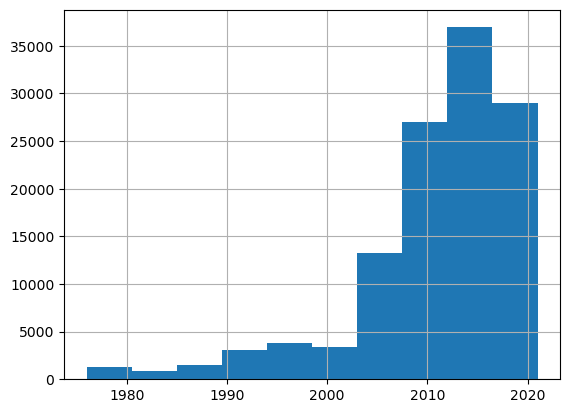

In [24]:

df.year.hist()

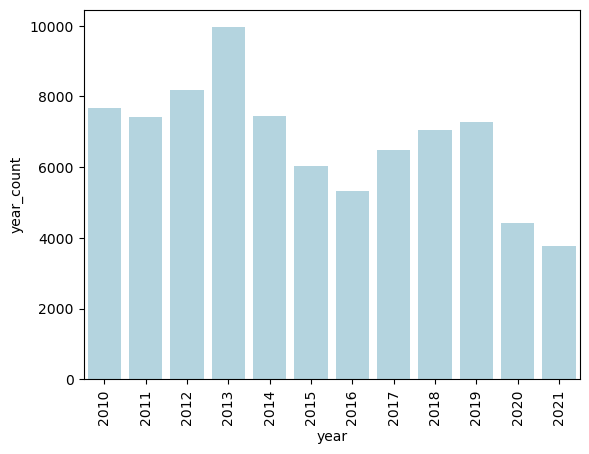

In [25]:
# Distribution of the publication year
# One bar per year, restrict to >=2010

# Count per year
df_year_counts = df[df.year >= 2010].groupby('year').year.count().to_frame('year_count').reset_index()
# Convert year from float to integer
df_year_counts['year'] = pd.to_numeric(df_year_counts.year, downcast='integer')
# Bar plot
ax = sns.barplot(data=df_year_counts, x='year', y='year_count', color='lightblue')
ax.tick_params(axis='x', rotation=90)


### Direction: Try to determine automatically based on activity_comment

The variable activities.activity_comment, when informed, it usually indicates if the result is active or inactive. This could be used to automatically define a direction, that is, whether higher values are more active (direction=1) or lower values are more active (direction=-1).

The idea is to compare the medians (e.g. if there are at least 30 values per group), or maybe better perform a t-test

In [26]:
df.activity_comment.value_counts()[:20]

Average; N=2                      1886
Average; N=2; Conc=25 Um ;        1566
Average; N=4                      1507
active                             497
Average; N=3                       352
Median N= 2                        131
Active                              32
Average n= 2; Conc: 32 ug.mL-1      18
Median N= 2; Maxinhib 12.2 Pct      11
Median N= 2; Maxinhib 13.3 Pct      11
Median N= 2; Maxinhib 11.2 Pct       9
Median N= 2; Maxinhib 10.2 Pct       9
Median N= 2; Maxinhib 10.9 Pct       8
Median N= 2; Maxinhib 9.8 Pct        7
Median N= 2; Maxinhib 12.8 Pct       7
Median N= 2; Maxinhib 5.2 Pct        7
Median N= 2; Maxinhib 12.7 Pct       7
Median N= 2; Maxinhib 10.8 Pct       7
Median N= 2; Maxinhib 9.1 Pct        7
Median N= 2; Maxinhib 13.2 Pct       6
Name: activity_comment, dtype: int64

In [27]:
# Define comment_active as True if activity_comment indicates 'Active', otherwise False.
# Note: there are no cases where the comment indicates 'Not Active' or 'Inactive'
df['comment_active'] = df['activity_comment'].str.upper().apply(lambda x: True if x=='ACTIVE' else False)

df.comment_active.value_counts()

False    126659
True        529
Name: comment_active, dtype: int64

In [28]:
# Percent of active by type and units

df_count_active = df.groupby(['standard_type', 'standard_units']).comment_active\
            .agg(['count', 'sum'])\
            .reset_index()\
            .rename(columns={'sum':'num_active'})

# Calculate ratio
df_count_active['ratio_active'] = df_count_active['num_active'] / df_count_active['count']

# Avoid displaying float scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df_count_active[df_count_active['count']>=2].sort_values(by=['ratio_active', 'num_active'], ascending=False).head(10)

,standard_type,standard_units,count,num_active,ratio_active
125,IC50,nM,4767,529,0.111
0,-Log C,mM l-1,44,0,0.000
1,-Log MIC,ug.mL-1,19,0,0.000
2,-log(1/MIC),N/A,97,0,0.000
3,-logMIC,N/A,844,0,0.000
4,ABBC,log10CFU/ml.hr,2,0,0.000
5,AUBC,log10CFU/ml.hr,39,0,0.000
6,AUC,ng.hr.mL-1,5,0,0.000
7,AUC,ug.mL-1,4,0,0.000
8,AUPAP,%,3,0,0.000


In [29]:
df[(df.standard_type=='IC50') & (df.standard_units=='nM')]\
            .groupby(['comment_active'])['standard_value']\
            .describe()

,count,mean,std,min,25%,50%,75%,max
comment_active,,,,,,,,
False,4238.000,24361.969,36590.573,0.010,180.000,4200.000,30100.000,100000.000
True,529.000,19457.698,15316.733,125.000,7450.000,15500.000,27300.000,78000.000


**Conclusion:**

The values 'Active' or 'Not active' in the variable activity_comment are normally used only when standard_value is missing.

An exception is the type 'IC50' with units 'nM', where there are a significant number of cases (529 out of 4767) where the standard_value is not missing but the activity_comment is 'active'. Here we still do not have cases marked 'not active'.

### Analyze pchembl_value

In [31]:
# Keep only rows where pchembl_value is informed
df_pchembl = df[df.pchembl_value.notnull()].copy()
df_pchembl.shape

(4033, 30)

In [32]:
df_pchembl.standard_units.value_counts()

nM    4033
Name: standard_units, dtype: int64

**Note:**
The pchembl_value variable is only informed if **standard_units is "nM"**

In [33]:
# Count cases where standard units is 'nM' but there is no pchembl_value
len(df[(df.standard_units=='nM') & (df.pchembl_value.isnull())])

12298

#### Plot standard_value vs pchembl_value

In [34]:
df_pchembl['log_standard_value'] = np.log10(df_pchembl['standard_value'])

<AxesSubplot:xlabel='pchembl_value', ylabel='standard_value'>

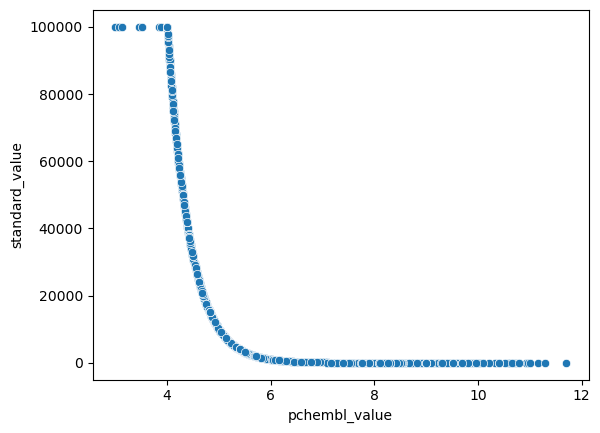

In [35]:
sns.scatterplot(data=df_pchembl, x='pchembl_value', y='standard_value')

<AxesSubplot:xlabel='pchembl_value', ylabel='log_standard_value'>

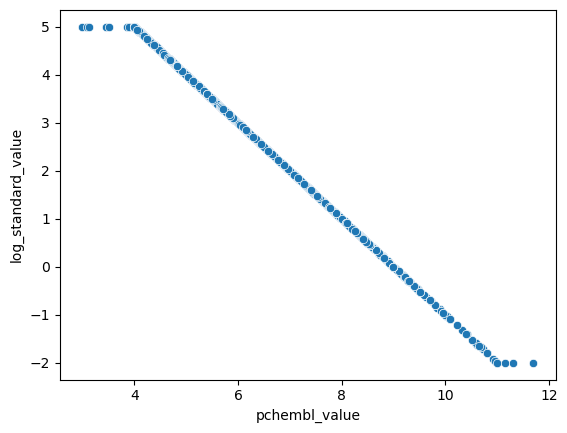

In [36]:
sns.scatterplot(data=df_pchembl, x='pchembl_value', y='log_standard_value')

Apparently the definition of **pchembl_value** (when standard_unit='nM') is the following:

$ pchembl = 9 - log_{10}(standard) $

Because 10^9 nM = 1 M, if the unit was 'M' the calculation would be simply:

$ pchembl = - log_{10}(standard) $
